In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow.compat.v1 as tf
from train import read_image, read_mask 

In [2]:
sess = tf.InteractiveSession()

In [3]:
frozen_graph = "./axial_frozen_graph.pb"

In [4]:
with tf.gfile.GFile(frozen_graph, "rb") as f: 
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [5]:
sess.graph.as_default()
tf.import_graph_def(graph_def)

In [6]:
input_tensor = sess.graph.get_tensor_by_name("x:0")
output_tensor = sess.graph.get_tensor_by_name("Identity:0")

In [7]:
print("Tensor Input : ", input_tensor)
print("Tensor Output: ", output_tensor)

Tensor Input :  Tensor("x:0", shape=(None, 600, 600, 1), dtype=float16)
Tensor Output:  Tensor("Identity:0", shape=(None, 600, 600, 12), dtype=float16)


In [8]:
img_path = "E:\\ISEF\\VHSCDD\\files\\images\\heart0-slice169_saggital.png"
img = read_image(img_path) 
img = np.expand_dims(img, axis=-1) 
img = [img]

TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [29]:
infrencing = sess.run(output_tensor, {'x:0': img})[0]


In [32]:
infrencing = infrencing.argmax(axis=-1)

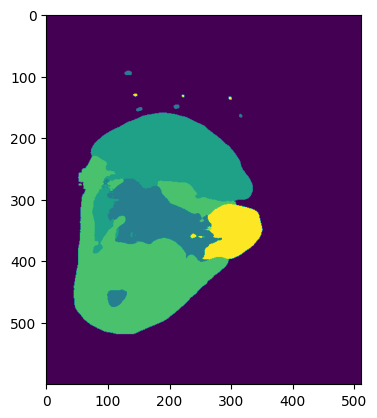

In [33]:
plt.imshow(infrencing)
plt.show()

### Calculate metrics with updated frozen graph 

In [9]:
import numpy as np
from metrics import dice_coef, dice_loss, dice_score, dice_score_per_class
from train import read_image, read_mask, specific_case_load_dataset, load_dataset
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
import os
import pandas as pd
import cv2

global VIEW


def test_model_with_dice_in_training(x_test, y_test, model_path):
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):

        DICE_SCORE = []

        for x, y in tqdm(zip(x_test, y_test), total=len(y_test)):
            name = x.split("/")[-1]

            """Reading the image"""
            x = read_image(x)
            x = np.expand_dims(x, axis=0)
            x = np.expand_dims(x, axis=-1)

            """Reading mask"""
            y = read_mask(y)
            y = np.argmax(y, axis=-1)
            y = y.astype(np.float32)

            """Prediction"""
            y_pred = sess.run(output_tensor, {'x:0': x})[0]
            y_pred = np.argmax(y_pred, axis=-1)
            y_pred = y_pred.astype(np.float32)

            y = y.flatten()
            y_pred = y_pred.flatten()

            """Calculating dice score"""
            dice_score_per_class_result = dice_score_per_class(
                y, y_pred, 12)
            DICE_SCORE.append(dice_score_per_class_result)

        dice_score_df = pd.DataFrame(DICE_SCORE, columns=["background",
                                                          "left_ventricle",
                                                          "right_ventricle",
                                                          "left_atrium",
                                                          "right_atrium",
                                                          "myocardium",
                                                          "descending_aorta",
                                                          "pulmonary_trunk",
                                                          "ascending_aorta",
                                                          "vena_cava",
                                                          "auricle",
                                                          "coronary_artery"])
        dice_score_df.to_csv(os.path.join(
            "files", f"{VIEW}", "normal_training", f"{VIEW}_dice-loss_dice-score-metric_normal.csv"))


"""Params"""
VIEW = "coronal"

"""Testing"""
(x_train, y_train), (x_val, y_val), (x_test,
                                        y_test) = load_dataset(".\\files", view=VIEW)

model_path = "C:\\Users\\Acer\\OneDrive\\Documents\\Model Data\\unet\\saggital_dice-loss_model_normal.h5"

test_model_with_dice_in_training(x_test, y_test, model_path)

Image: 20400 || Mask: 20400


  1%|          | 32/4080 [00:18<38:19,  1.76it/s] 


KeyboardInterrupt: 